In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/Bengisu/DL/CaltechTinySplit.zip -d CaltechTinySplit

Archive:  /content/drive/MyDrive/Bengisu/DL/CaltechTinySplit.zip
   creating: CaltechTinySplit/CaltechTinySplit/test/
   creating: CaltechTinySplit/CaltechTinySplit/test/camera/
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/image_0024.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/image_0035.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/image_0037.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/image_0040.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/image_0046.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/camera/Thumbs.db  
   creating: CaltechTinySplit/CaltechTinySplit/test/cannon/
  inflating: CaltechTinySplit/CaltechTinySplit/test/cannon/image_0024.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/cannon/image_0035.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/cannon/image_0037.jpg  
  inflating: CaltechTinySplit/CaltechTinySplit/test/cannon/image_0038.jpg  
  infla

In [ ]:
os.chdir("/content/CaltechTinySplit/CaltechTinySplit")

image_size=(224,224)
IMG_SIZE = 224
batch_size = 16
labels = ['camera', 'cannon','cellphone', 'Faces','flamingo', 'hawksbill','ibis', 'Motorbikes','pizza']

train_path = 'train'
test_path = 'test'
val_path = 'val'

classes = os.listdir(train_path)

classes

['cellphone',
 'hawksbill',
 'flamingo',
 'camera',
 'Motorbikes',
 'Faces',
 'pizza',
 'cannon',
 'ibis']

In [ ]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_path, cls, x), os.listdir(os.path.join(train_path, cls)))) for cls in classes}

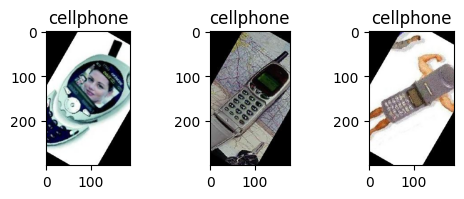

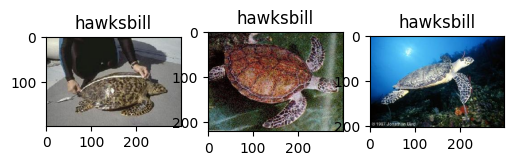

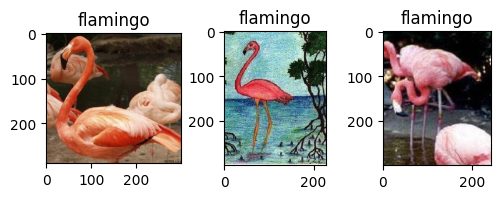

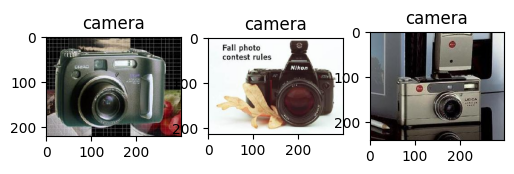

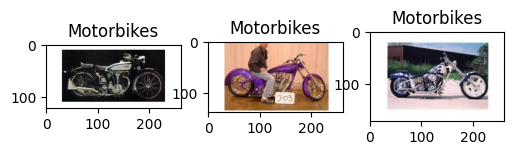

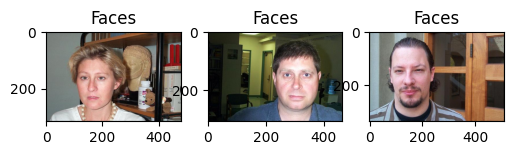

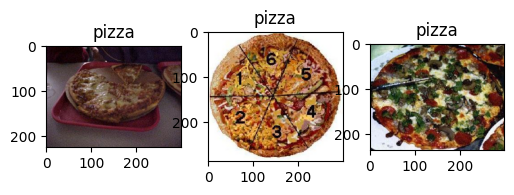

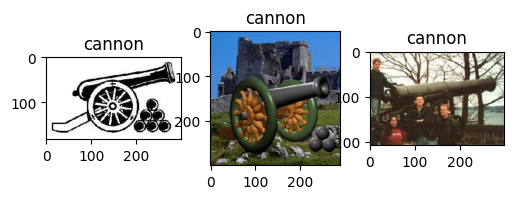

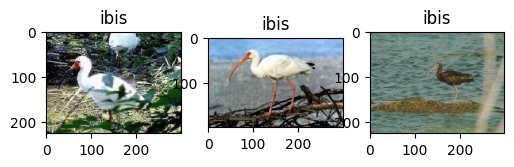

In [ ]:
for cls in classes:
  plt.figure(figsize=(8, 8))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 4):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

In [ ]:
train_class_paths = [os.path.join(train_path, cls) for cls in classes]
val_class_paths = [os.path.join(val_path, cls) for cls in classes]
test_class_paths = [os.path.join(test_path, cls) for cls in classes]

In [ ]:

train_ds = image_dataset_from_directory(train_path,
                                        image_size = (IMG_SIZE,IMG_SIZE),
                                        seed = 132,
                                        batch_size = batch_size,
                                        color_mode = 'grayscale',
                                        shuffle = True)

val_ds = image_dataset_from_directory(val_path,
                                        image_size = (IMG_SIZE,IMG_SIZE),
                                        seed = 132,
                                        batch_size = batch_size,
                                        color_mode = 'grayscale',
                                        shuffle = True)

test_ds = image_dataset_from_directory(test_path,
                                       image_size = (IMG_SIZE,IMG_SIZE),
                                       seed = 132,
                                       batch_size = batch_size,
                                       color_mode = 'grayscale',
                                       shuffle = True)

Found 1346 files belonging to 9 classes.
Found 165 files belonging to 9 classes.
Found 174 files belonging to 9 classes.


In [ ]:
x_train = tf.concat([x for x, y in train_ds], axis = 0)
y_train = tf.concat([y for x, y in train_ds], axis = 0)

x_val = tf.concat([x for x, y in val_ds], axis = 0)
y_val = tf.concat([y for x, y in val_ds], axis = 0)

x_test = tf.concat([x for x, y in test_ds], axis = 0)
y_test = tf.concat([y for x, y in test_ds], axis = 0)

tf.compat.v1.enable_eager_execution()

In [ ]:
x_train = np.array(x_train).astype('uint8')
y_train = np.array(y_train).astype('uint8')

x_val = np.array(x_val).astype('uint8')
y_val = np.array(y_val).astype('uint8')

x_test = np.array(x_test).astype('uint8')
y_test = np.array(y_test).astype('uint8')

In [ ]:
input_shape = image_size + (1,)
input_shape

(224, 224, 1)

In [ ]:
inputs = keras.Input(shape = input_shape)

x = layers.Rescaling(1./255)(inputs)
x

<KerasTensor: shape=(None, 224, 224, 1) dtype=float32 (created by layer 'rescaling')>

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3), padding='same', activation=tf.keras.activations.swish))
model.add(Conv2D(filters=128, kernel_size=(3), padding='same', activation=tf.keras.activations.swish))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=128, kernel_size=(3), padding='same', activation=tf.keras.activations.swish))
model.add(Conv2D(filters=128, kernel_size=(3), padding='same', activation=tf.keras.activations.swish))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(9, activation=tf.keras.activations.swish))
model.add(Dense(9, activation=tf.keras.activations.swish))
model.add(Dense(9, activation='softmax')) #burayi 9 yapacaksaniz

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)


In [ ]:
import tensorflow as tf


model_name_save= '/content/hw4_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name_save, save_freq='epoch', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(  monitor='val_accuracy', patience=7, verbose=1,  mode='max',restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(  monitor='val_accuracy', factor=0.3, patience=7,  min_lr=1e-3, verbose=1,  mode='max')

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1)
datagen.fit(x_train)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=len(x_train)//16, epochs=60, validation_data=(x_val, y_val), callbacks=[reduce_lr, checkpoint, early_stop])


Epoch 1/60
84/84 [==============================] - ETA: 0s - loss: 2.1169 - accuracy: 0.4759 
Epoch 1: val_accuracy improved from -inf to 0.47879, saving model to /content/hw4_model.hdf5
84/84 [==============================] - 2204s 26s/step - loss: 2.1169 - accuracy: 0.4759 - val_loss: 2.0577 - val_accuracy: 0.4788 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
84/84 [==============================] - ETA: 0s - loss: 1.9989 - accuracy: 0.4744 
Epoch 2: val_accuracy did not improve from 0.47879
84/84 [==============================] - 2153s 26s/step - loss: 1.9989 - accuracy: 0.4744 - val_loss: 1.9309 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 3/60
84/84 [==============================] - ETA: 0s - loss: 1.8731 - accuracy: 0.4744 
Epoch 3: val_accuracy did not improve from 0.47879
84/84 [==============================] - 2149s 26s/step - loss: 1.8731 - accuracy: 0.4744 - val_loss: 1.8054 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 4/60
84/84 [==============================] - ETA: 0s - loss: 1.7618 - accuracy: 0.4722 
Epoch 4: val_accuracy did not improve from 0.47879
84/84 [==============================] - 2152s 26s/step - loss: 1.7618 - accuracy: 0.4722 - val_loss: 1.7020 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 5/60
84/84 [==============================] - ETA: 0s - loss: 1.6722 - accuracy: 0.4752 
Epoch 5: val_accuracy did not im

In [ ]:
score = model.evaluate(x_val, y_val, batch_size=16)
score

11/11 [==============================] - 91s 8s/step - loss: 1.5570 - accuracy: 0.4788


[1.5570156574249268, 0.4787878692150116]

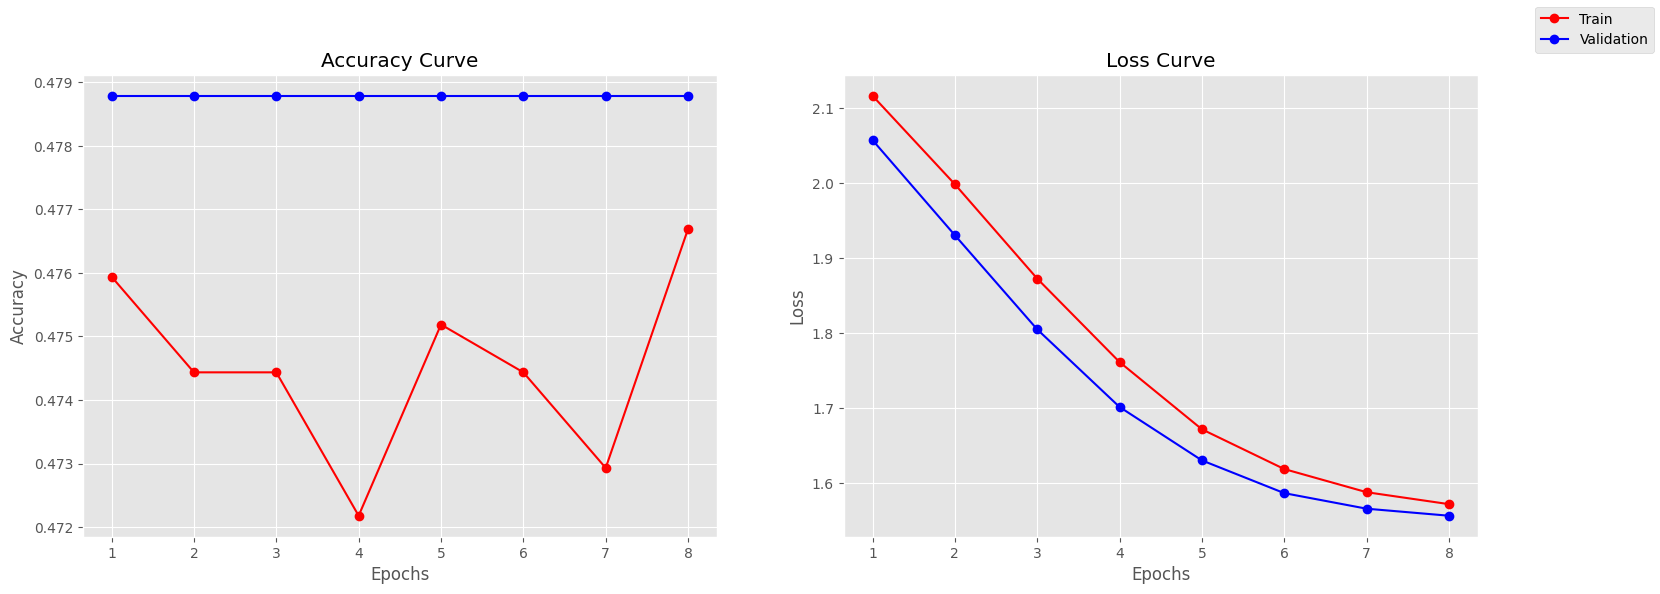

In [ ]:
plt.style.use('ggplot')
figure, axes = plt.subplots(1, 2, figsize=(18, 6))
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Accuracy
axes[0].plot(epochs, history.history['accuracy'], 'ro-')
axes[0].plot(epochs, history.history['val_accuracy'], 'bo-')
axes[0].set(xlabel='Epochs', ylabel='Accuracy', title='Accuracy Curve')

# Plot Loss
axes[1].plot(epochs, history.history['loss'], 'ro-')
axes[1].plot(epochs, history.history['val_loss'], 'bo-')
axes[1].set(xlabel='Epochs', ylabel='Loss', title='Loss Curve')

figure.legend(['Train', 'Validation'])
plt.show()


In [ ]:
yhat_probs = model.predict(x_test, verbose=0)
yhat_classes = ((yhat_probs) > 0.5).astype("int32")
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
yyy = np.argmax(y_test, axis=1)

print(f'accuracy score: {accuracy_score(yyy, yhat_classes)}')

precision = precision_score(yyy, yhat_classes,pos_label='positive', average='macro')
print('precision: %f' % precision)

recall = recall_score(yyy, yhat_classes,average='macro')
print('recall: %f' % recall)


f1 = f1_score(yyy, yhat_classes,average='macro')
print('f1 score: %f' % f1)

accuracy score: 0.25287356321839083
precision: 0.028097
recall: 0.111111
f1 score: 0.044852


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[44  0  0  0  0  0  0  0  0]
 [81  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0]]


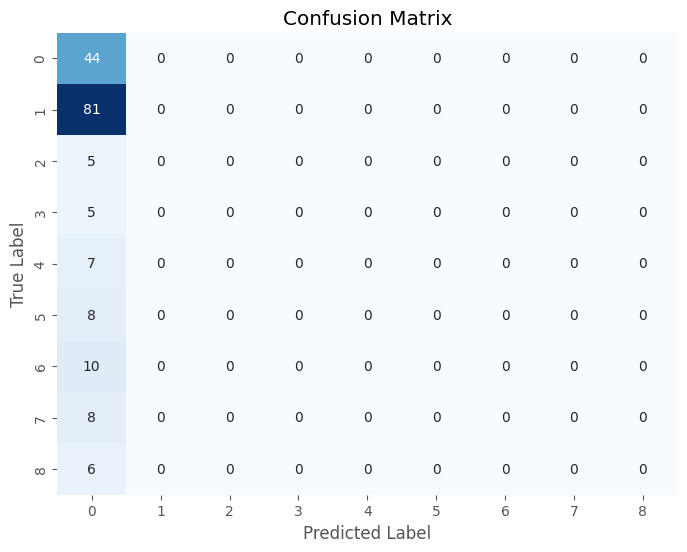

In [ ]:
yyy = np.argmax(y_test, axis=1)

matrix = confusion_matrix(yyy, yhat_classes)
print(matrix)
conf_matrix_np = np.array(matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(conf_matrix_np.shape[1]), yticklabels=range(conf_matrix_np.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()